In [ ]:
-Evaluate the stability of CKD risk predictions under noisy clinical measurements, simulating real-world lab variability

# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [2]:
import joblib
import matplotlib.pyplot as plt

numeric_model = joblib.load("../models/numeric_model.pkl")


In [3]:
df = pd.read_csv("../data/processed/ckd_processed.csv")

numeric_features = [
    'Al', 'Bp', 'Bu', 'Hemo', 'Pot',
    'Rbcc', 'Sc', 'Sg', 'Sod', 'Su', 'Wbcc'
]

X = df[numeric_features]
y = df["Class"]


In [4]:
valid_idx = X.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]


In [5]:
baseline_probs = numeric_model.predict_proba(X)[:, 1]


In [6]:
def add_gaussian_noise(X, noise_level=0.05):
    """
    Add Gaussian noise proportional to feature scale.
    noise_level = 0.05 means 5% noise
    """
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise


In [7]:
noise_levels = [0.01, 0.05, 0.10]
mean_prediction_shift = {}

for nl in noise_levels:
    X_noisy = add_gaussian_noise(X, noise_level=nl)
    noisy_probs = numeric_model.predict_proba(X_noisy)[:, 1]
    
    mean_shift = np.mean(np.abs(baseline_probs - noisy_probs))
    mean_prediction_shift[nl] = mean_shift

mean_prediction_shift


{0.01: np.float64(0.0009151889297083468),
 0.05: np.float64(0.004891505020808431),
 0.1: np.float64(0.008605415281331736)}

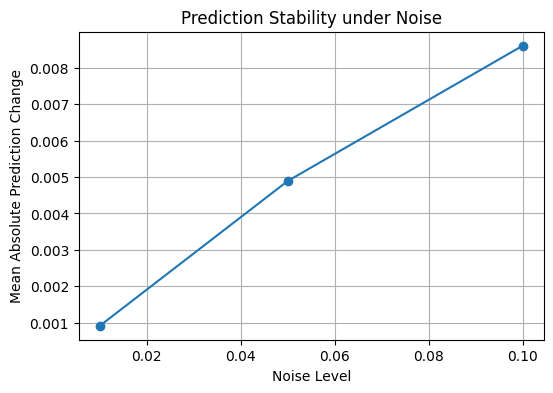

In [8]:
plt.figure(figsize=(6,4))
plt.plot(
    list(mean_prediction_shift.keys()),
    list(mean_prediction_shift.values()),
    marker='o'
)
plt.xlabel("Noise Level")
plt.ylabel("Mean Absolute Prediction Change")
plt.title("Prediction Stability under Noise")
plt.grid(True)
plt.show()


In [9]:
sample_idx = np.random.choice(len(X), size=10, replace=False)

for idx in sample_idx:
    original = baseline_probs[idx]
    noisy = numeric_model.predict_proba(
        add_gaussian_noise(X.iloc[[idx]], noise_level=0.05)
    )[0, 1]
    
    print(f"Patient {idx}: Original={original:.3f}, Noisy={noisy:.3f}")


Patient 136: Original=1.000, Noisy=1.000
Patient 292: Original=0.004, Noisy=0.004
Patient 366: Original=0.015, Noisy=0.013
Patient 390: Original=0.016, Noisy=0.016
Patient 194: Original=0.980, Noisy=0.977
Patient 395: Original=0.044, Noisy=0.058
Patient 392: Original=0.087, Noisy=0.112
Patient 180: Original=1.000, Noisy=1.000
Patient 259: Original=0.020, Noisy=0.019
Patient 102: Original=0.248, Noisy=0.270


In [ ]:
## Robustness Analysis Interpretation

-The numeric-only CKD risk model demonstrated stable predictive behavior under simulated clinical noise. As noise levels increased from 1% to 10%, the average change in predicted risk remained limited, indicating resilience to moderate laboratory measurement variability. This robustness is essential for real-world deployment, where clinical inputs are subject to instrumentation and reporting noise.
